In [1]:
import numpy as np
import os
import matplotlib.pyplot as plt

In [2]:
joint_training_paste = [0.411] * 10

finetuning = [
	[0.515], 
	[0.102, 0.778], 
	[0.072, 0.110, 0.524], 
	[0.152, 0.181, 0.056, 0.484], 
	[0.158, 0.119, 0.060, 0.052, 0.784], 
	[0.174, 0.180, 0.108, 0.109, 0.383, 0.704],
	[0.132, 0.126, 0.056, 0.025, 0.449, 0.215, 0.615],
	[0.076, 0.116, 0.056, 0.025, 0.400, 0.465, 0.100, 0.484],
	[0.108, 0.164, 0.059, 0.058, 0.337, 0.123, 0.119, 0.120, 0.512],
	[0.073, 0.180, 0.081, 0.099, 0.210, 0.199, 0.198, 0.093, 0.085, 0.163],
]

replay_paste_mem100 = [
	[0.560], 
	[0.462, 0.755], 
	[0.360, 0.748, 0.339],
	[0.410, 0.745, 0.297, 0.453],
	[0.330, 0.725, 0.273, 0.417, 0.689],
	[0.304, 0.738, 0.266, 0.420, 0.672, 0.578],
	[0.314, 0.725, 0.235, 0.421, 0.622, 0.496, 0.559],
	[0.244, 0.669, 0.227, 0.360, 0.616, 0.468, 0.461, 0.444],
	[0.347, 0.693, 0.238, 0.402, 0.634, 0.470, 0.486, 0.353, 0.449],
	[0.315, 0.693, 0.208, 0.395, 0.610, 0.495, 0.451, 0.356, 0.368, 0.080]
]

replay_stfpm_mcunet_mem100 = [
	[0.516],
	[0.418, 0.796],
	[0.317, 0.750, 0.287],
	[0.258, 0.707, 0.247, 0.395],
	[0.118, 0.628, 0.146, 0.232, 0.505],
	[0.260, 0.722, 0.231, 0.342, 0.589, 0.616],
	[0.165, 0.696, 0.184, 0.228, 0.529, 0.411, 0.485],
	[0.188, 0.664, 0.194, 0.235, 0.557, 0.535, 0.574, 0.350],
	[0.187, 0.707, 0.189, 0.309, 0.571, 0.468, 0.598, 0.324, 0.411],
	[0.186, 0.680, 0.197, 0.312, 0.451, 0.514, 0.562, 0.330, 0.281, 0.105],
]

replay_stfpm_resenet18_mem100 = [
	[0.640],
	[0.627, 0.693],
	[0.591, 0.636, 0.376],
	[0.597, 0.627, 0.350, 0.400],
	[0.561, 0.626, 0.332, 0.402, 0.595],
	[0.574, 0.607, 0.329, 0.323, 0.513, 0.638],
	[0.547, 0.609, 0.330, 0.319, 0.488, 0.622, 0.564],
	[0.560, 0.566, 0.290, 0.305, 0.484, 0.629, 0.566, 0.408],
	[0.537, 0.581, 0.297, 0.336, 0.488, 0.625, 0.538, 0.344, 0.609],
	[0.506, 0.595, 0.283, 0.338, 0.497, 0.610, 0.559, 0.344, 0.583, 0.291],
]

compressed_replay_paste_mem100 = [
	[0.564], 
	[0.487, 0.763],
	[0.467, 0.728, 0.336],
	[0.428, 0.725, 0.296, 0.452],
	[0.395, 0.732, 0.274, 0.417, 0.699],
	[0.391, 0.714, 0.247, 0.419, 0.633, 0.592],
	[0.324, 0.702, 0.240, 0.435, 0.686, 0.523, 0.558],
	[0.264, 0.701, 0.216, 0.399, 0.630, 0.526, 0.522, 0.440],
	[0.297, 0.726, 0.229, 0.423, 0.660, 0.508, 0.536, 0.367, 0.443],
	[0.299, 0.702, 0.234, 0.379, 0.571, 0.490, 0.506, 0.370, 0.391, 0.095],
]

quantized_compressed_replay_paste_mem100 = [
	[0.609],
	[0.557, 0.674],
	[0.554, 0.635, 0.255],
	[0.562, 0.623, 0.216, 0.406],
	[0.526, 0.574, 0.191, 0.374, 0.635],
	[0.560, 0.562, 0.188, 0.361, 0.597, 0.470],
	[0.562, 0.549, 0.180, 0.356, 0.576, 0.403, 0.464],
	[0.537, 0.533, 0.158, 0.290, 0.544, 0.375, 0.432, 0.304],
	[0.556, 0.532, 0.168, 0.346, 0.541, 0.349, 0.425, 0.241, 0.282],
	[0.548, 0.503, 0.154, 0.253, 0.504, 0.331, 0.408, 0.200, 0.163, 0.139]
]

pca_compression_compressed_replay_paste_mem100_variance098 = [
	[0.612],
	[0.556, 0.675],
	[0.558, 0.628, 0.246],
	[0.557, 0.611, 0.208, 0.372],
	[0.534, 0.546, 0.179, 0.341, 0.636],
	[0.551, 0.551, 0.185, 0.318, 0.568, 0.472],
	[0.519, 0.546, 0.170, 0.298, 0.578, 0.427, 0.454],
	[0.491, 0.509, 0.157, 0.273, 0.572, 0.411, 0.405, 0.304],
	[0.505, 0.513, 0.158, 0.304, 0.553, 0.317, 0.391, 0.242, 0.323],
	[0.541, 0.467, 0.152, 0.280, 0.489, 0.290, 0.352, 0.217, 0.199, 0.099],
]


In [3]:
def prepare_data(data):
    """
    Prepares learning curve data by calculating the average F1 score of seen tasks at each step.
    
    Args:
        data (list of lists): Each sublist contains F1 scores for seen tasks at that step
        
    Returns:
        list: Average F1 scores for each step (10 values for 10 tasks)
    """
    averages = []
    
    for task_results in data:
        avg = sum(task_results) / len(task_results)
        averages.append(round(avg, 3))
        
    return averages

In [4]:
num_tasks = 10
tasks = np.arange(num_tasks)

In [9]:
plt.figure(figsize=(10, 6))

plt.plot(tasks, prepare_data(compressed_replay_paste_mem100), '-', label='Compressed-Replay-100 PASTE mcunet', color='green')
plt.plot(tasks, prepare_data(replay_stfpm_mcunet_mem100), '-', label='Replay-100 STFPM mcunet ', color='orange')
plt.plot(tasks, prepare_data(replay_paste_mem100), '-', label='Replay-100 PASTE mcunet', color='blue')
plt.plot(tasks, prepare_data(replay_stfpm_resenet18_mem100), '-', label='Replay-100 STFPM resnet18', color='purple')
plt.plot(tasks, joint_training_paste, '-', label='Joint Training PASTE mcunet', color='red')
plt.plot(tasks, prepare_data(finetuning), '-', label='Fine-Tuning PASTE mcunet', color='pink')

plt.grid(True)
plt.xlabel('Task')
plt.ylabel('F1 pixel-level')
plt.title('F1 pixel-level results')
plt.legend()

plt.grid(True, which='minor', linestyle='--', alpha=0.4)
plt.grid(True, which='major', linestyle='-', alpha=0.6)

plt.tight_layout()

layer_dir = os.path.join('plots', 'f1_pixel_level')
os.makedirs(layer_dir, exist_ok=True)
plot_filename = os.path.join(layer_dir, 'f1_pixel_level_with_resnet_replay.png')
plt.savefig(plot_filename)

plt.close()

In [50]:
plt.figure(figsize=(10, 6))

plt.plot(tasks, prepare_data(pca_compression_compressed_replay_paste_mem100_variance098), '-', label='PCA-Compression-Compressed-Replay-100 PASTE', color='blue')
plt.plot(tasks, prepare_data(quantized_compressed_replay_paste_mem100), '-', label='Quantized-Compressed-Replay-100 PASTE', color='orange')
plt.plot(tasks, prepare_data(compressed_replay_paste_mem100), '-', label='Compressed-Replay-100 PASTE', color='green')
plt.plot(tasks, joint_training_paste, '-', label='Joint Training PASTE', color='red')
plt.plot(tasks, prepare_data(finetuning), '-', label='Fine-Tuning PASTE', color='pink')

plt.grid(True)
plt.xlabel('Task')
plt.ylabel('F1 pixel-level')
plt.title('F1 pixel-level results')
plt.legend()

plt.grid(True, which='minor', linestyle='--', alpha=0.4)
plt.grid(True, which='major', linestyle='-', alpha=0.6)

plt.tight_layout()

layer_dir = os.path.join('plots', 'f1_pixel_level')
os.makedirs(layer_dir, exist_ok=True)
plot_filename = os.path.join(layer_dir, 'f1_pixel_level_compression.png')
plt.savefig(plot_filename)

plt.close()

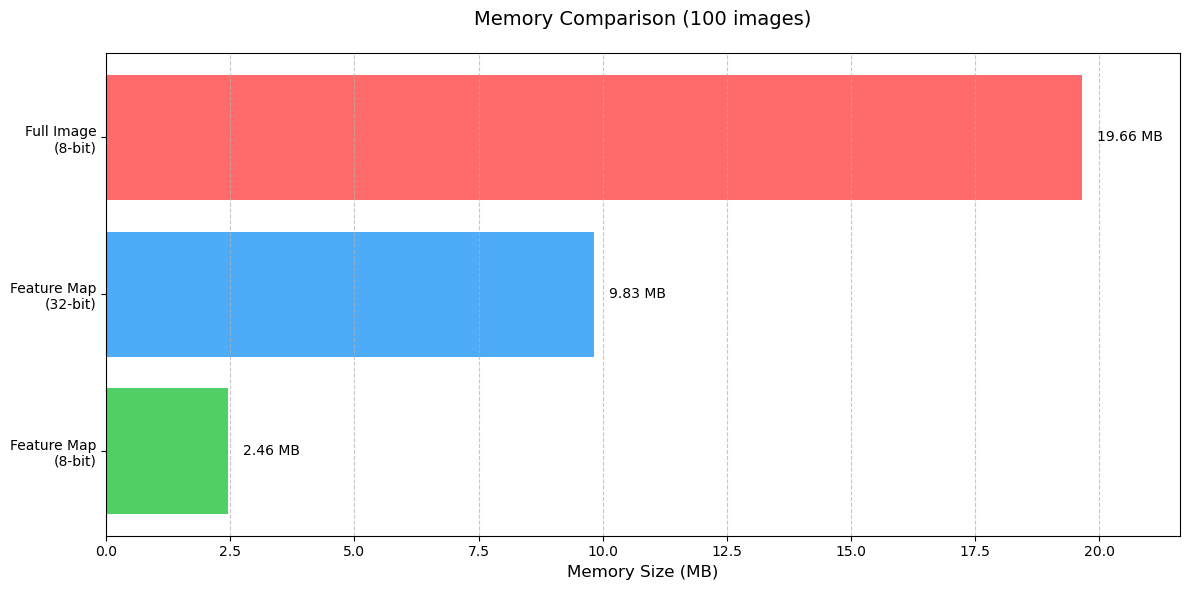

In [11]:
# Data
formats = ['Full Image\n(8-bit)', 'Feature Map\n(32-bit)', 'Feature Map\n(8-bit)']
memory_sizes = [19.66, 9.83, 2.46]  # in MB
colors = ['#ff6b6b', '#4dabf7', '#51cf66']

# Create figure and axis
plt.figure(figsize=(12, 6))

# Create horizontal bar chart
bars = plt.barh(formats, memory_sizes, color=colors)

# Customize the plot
plt.title('Memory Comparison (100 images)', pad=20, fontsize=14)
plt.xlabel('Memory Size (MB)', fontsize=12)

# Set x-axis limits to accommodate labels
max_value = max(memory_sizes)
plt.xlim(0, max_value * 1.1)  # Extend x-axis by 20% to fit labels

# Add value labels on the bars
for bar in bars:
    width = bar.get_width()
    plt.text(width + 0.3, bar.get_y() + bar.get_height()/2,
             f'{width} MB',
             ha='left', va='center', fontsize=10)

# Add a grid for better readability
plt.grid(axis='x', linestyle='--', alpha=0.7)

# Customize the layout
plt.gca().invert_yaxis()  # Invert y-axis to match the original order

# Add explanatory text
# plt.figtext(0.02, 0.02, 
#             'Compression ratios:\n' +
#             '• Feature Map 32-bit vs Full Image: 2x smaller\n' +
#             '• Feature Map 8-bit vs Full Image: 8x smaller\n' +
#             '• Feature Map 8-bit vs Feature Map 32-bit: 4x smaller',
#             fontsize=8, ha='left', va='bottom')

# Adjust layout to prevent text cutoff
plt.tight_layout()

# Show plot
plt.show()

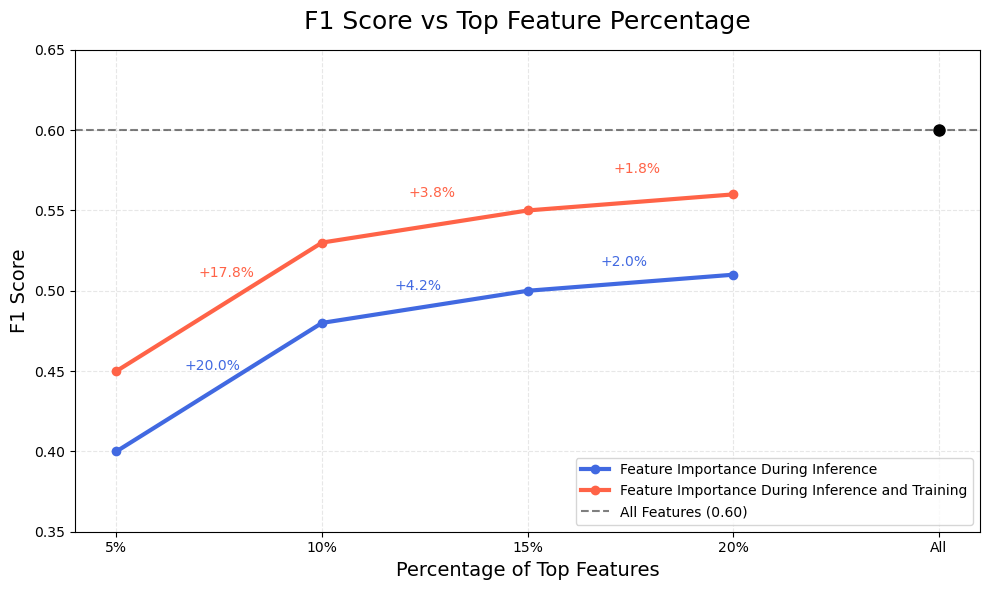

In [6]:
import matplotlib.pyplot as plt
import numpy as np

# Data
percentages = [5, 10, 15, 20, 100]
f1_scores_inference = [0.40, 0.48, 0.50, 0.51, 0.60]
f1_scores_training = [0.45, 0.53, 0.55, 0.56, 0.60]

# Create figure and axis with a specific size
plt.figure(figsize=(10, 6))
# plt.style.use('dark_background')

# Use more evenly spaced positions for visualization
visual_positions = [5, 10, 15, 20, 25]

# Plot line for Feature Importance During Inference
plt.plot(visual_positions[:4], f1_scores_inference[:4], 'o-', color='#4169E1', linewidth=3, 
         label='Feature Importance During Inference')

# Plot line for Feature Importance During Training and Inference
plt.plot(visual_positions[:4], f1_scores_training[:4], 'o-', color='#FF6347', linewidth=3,
         label='Feature Importance During Inference and Training')

# Plot the 'All features' point separately without connecting line
plt.plot(visual_positions[-1], f1_scores_training[-1], 'o', color='black', markersize=8)

# Add reference line for all features
plt.axhline(y=f1_scores_inference[-1], color='black', linestyle='--', alpha=0.5,
           label='All Features (0.60)')

# Customize the plot
plt.grid(True, linestyle='--', alpha=0.3)
plt.xlabel('Percentage of Top Features', fontsize=14)
plt.ylabel('F1 Score', fontsize=14)
plt.title('F1 Score vs Top Feature Percentage', fontsize=18, pad=15)

# Set x-axis ticks
plt.xticks(visual_positions, [f'{p}%' if p != 100 else 'All' for p in percentages])

# Set y-axis limits with some padding
plt.ylim(0.35, 0.65)

# Calculate improvements for consecutive measurements only
improvements_inference = []
improvements_training = []
for i in range(1, len(f1_scores_inference)-1):  # Stop before 'All' features
    imp_inference = ((f1_scores_inference[i] - f1_scores_inference[i-1]) / f1_scores_inference[i-1]) * 100
    imp_training = ((f1_scores_training[i] - f1_scores_training[i-1]) / f1_scores_training[i-1]) * 100
    improvements_inference.append(f'+{imp_inference:.1f}%')
    improvements_training.append(f'+{imp_training:.1f}%')

# Add improvement annotations
for i in range(len(improvements_inference)):
    plt.annotate(improvements_inference[i], 
                xy=((visual_positions[i] + visual_positions[i+1])/2, 
                    (f1_scores_inference[i] + f1_scores_inference[i+1])/2),
                xytext=(-5, 10),
                textcoords='offset points',
                ha='center',
                va='bottom',
                color='#4169E1')
    plt.annotate(improvements_training[i],
                xy=((visual_positions[i] + visual_positions[i+1])/2,
                    (f1_scores_training[i] + f1_scores_training[i+1])/2 + 0.034),
                xytext=(5, -10),
                textcoords='offset points',
                ha='center',
                va='top',
                color='#FF6347')

plt.legend(loc='lower right')
plt.tight_layout()
plt.show()